In [1]:
from ultralytics import YOLO

import matplotlib.pyplot as plt
import cv2
import sys
import os
import time
import json
import numpy as np
from shapely.geometry import Polygon
from scipy.optimize import linear_sum_assignment

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch

In [2]:
# loading yolov11 model
model_yolo = YOLO("checkpoints/YOLO11/yolo11x.pt")

In [3]:
# loading sam2.1 model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint = "checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"

sam2_model = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2_model)

In [5]:
# utils
def segment_yolo_sam2(model_yolo, predictor, image_path, conf=0.05):
    results = model_yolo.predict(image_path, classes=[2, 3, 5], conf=conf)
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)

    input_boxes = np.array([bbox.data.cpu().numpy()[0][:4] for bbox in results[0].boxes])
    
    if input_boxes.size == 0:
        return []

    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    if len(masks) == 1:
        return np.array([masks])
    return masks

def load_forbidden_bboxes(json_path):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)

    input_areas = {}
    input_points = {}
    for obj in json_data['objects']:
        info = obj['tags'].split(';')
        obj_id = None
        obj_type = None
        for i in info:
            if i.startswith("id"):
                obj_id = i.split()[-1]
            if i.startswith('class'):
                obj_type = i.split()[-1]
        if obj_id is not None:
            if obj_type == 'point':
                input_points[obj_id] = obj['points'][0]
            elif obj_type == 'area':
                input_areas[obj_id] = obj['points']

    input_boxes = {}
    for k, v in input_areas.items():
        area_points = np.array(v)
        x_min, x_max = area_points[:, 0].min(), area_points[:, 0].max()
        y_min, y_max = area_points[:, 1].min(), area_points[:, 1].max()
        input_boxes[k] = [x_min, y_min, x_max, y_max]

    keys = list(input_points.keys())
    return [input_boxes[k] for k in keys], [input_points[k] for k in keys]

In [22]:
def create_mask_allowed(model_yolo, predictor, image_path, height=1080, width=1920, conf=0.05):
    masks = segment_yolo_sam2(model_yolo, predictor, image_path, conf = conf)

    combined_mask = np.zeros((height, width), dtype=np.uint8)
    
    for mask in masks:
        mask = mask.squeeze(0).astype(np.uint8)  
        combined_mask = np.maximum(combined_mask, mask)

    return combined_mask

def create_mask_forbidden(predictor, image_path, forbidden_info, height=1080, width=1920):
    for k in forbidden_info:
        if k in image_path:
            input_boxes, input_points = forbidden_info[k]
            break

    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    predictor.set_image(image_rgb)

    input_boxes = np.array(input_boxes)
    input_points = np.array([[ip] for ip in input_points])
    input_labels = np.array([[1] for _ in input_points])

    masks = []
    for box, point, label in zip(input_boxes, input_points, input_labels):
        mask, _, _ = predictor.predict(
            point_coords=point,
            point_labels=label,
            box=box,
            multimask_output=False,
        )
        masks.append(mask)

    combined_mask = np.zeros((height, width), dtype=np.uint8)
        
    for mask in masks:
        mask = mask.squeeze(0).astype(np.uint8)  
        combined_mask = np.maximum(combined_mask, mask)

    return combined_mask

def process_masks(mask_allowed, mask_forbidden, color_allowed=[0, 255, 0], color_forbidden=[0, 0, 255]):
    mask_forbidden[mask_allowed > 0] = 0

    mask_allowed_rgba = np.zeros((mask_allowed.shape[0], mask_allowed.shape[1], 4), dtype=np.uint8)
    mask_allowed_rgba[:, :, :3] = color_allowed
    mask_allowed_rgba[:, :, 3] = mask_allowed * 255

    mask_forbidden_rgba = np.zeros((mask_forbidden.shape[0], mask_forbidden.shape[1], 4), dtype=np.uint8)
    mask_forbidden_rgba[:, :, :3] = color_forbidden
    mask_forbidden_rgba[:, :, 3] = mask_forbidden * 255
    return mask_allowed_rgba, mask_forbidden_rgba

In [27]:
input_dir = r'/mnt/c/Users/gtraw/Projekt_badawczy/11_13_full'
output_dir = r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results'

forbidden_info = {
    'weti1': load_forbidden_bboxes(r"/mnt/c/Users/gtraw/Projekt_badawczy/images/forbidden1.json"),
    'weti2': load_forbidden_bboxes(r"/mnt/c/Users/gtraw/Projekt_badawczy/images/forbidden2.json")
}

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

for image_file in os.listdir(input_dir):
    
    if not image_file.endswith(('jpg', 'png')):
        continue
    print(f"\nImage: {image_file}")

    image_path = os.path.join(input_dir, image_file)

    mask_allowed = create_mask_allowed(model_yolo, predictor, image_path)
    mask_forbidden = create_mask_forbidden(predictor, image_path, forbidden_info)
    mask_allowed, mask_forbidden = process_masks(mask_allowed, mask_forbidden)
        
    output_mask_path = os.path.join(output_dir, image_file.replace('.jpg', '_allowed.png'))
    cv2.imwrite(output_mask_path, mask_allowed)
    print(f"Saved allowed mask to: {output_mask_path}")
        
    output_mask_path = os.path.join(output_dir, image_file.replace('.jpg', '_forbidden.png'))
    cv2.imwrite(output_mask_path, mask_forbidden)
    print(f"Saved allowed mask to: {output_mask_path}")


Image: weti1_2024_11_13_09_17.jpg



image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/11_13_full/weti1_2024_11_13_09_17.jpg: 384x640 9 cars, 191.1ms
Speed: 3.2ms preprocess, 191.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Saved allowed mask to: /mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results/weti1_2024_11_13_09_17_allowed.png
Saved allowed mask to: /mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results/weti1_2024_11_13_09_17_forbidden.png

Image: weti1_2024_11_13_09_18.jpg

image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/11_13_full/weti1_2024_11_13_09_18.jpg: 384x640 9 cars, 21.5ms
Speed: 1.8ms preprocess, 21.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Saved allowed mask to: /mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results/weti1_2024_11_13_09_18_allowed.png
Saved allowed mask to: /mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results/weti1_2024_11_13_09_18_forbidden.png

Image: weti1_2024_11_13_09_19.jpg

image 1/1 /mnt/c/Users/gtraw/Pro

In [109]:
def fetch_image_paths(input_dir, required_substrings=[], exclude_substrings=[]):
    image_paths = []
    for image_file in os.listdir(input_dir):
        if not image_file.endswith(('jpg', 'png')):
            continue

        not_found = False
        for rs in required_substrings:
            if rs not in image_file:
                not_found = True
                break
        for es in exclude_substrings:
            if es in image_file:
                not_found = True
                break
        if not_found:
            continue

        image_paths.append(os.path.join(input_dir, image_file))
    return image_paths

def combine_masks(image_paths, output_path=None, transparency=None, height=1080, width=1920):
    if transparency is None:
        transparency = 1 / len(image_paths)

    transparent_image = np.zeros((height, width, 4), dtype=np.float32)

    for image_path in image_paths:
        mask = cv2.imread(image_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.0
        transparent_image = cv2.addWeighted(transparent_image, 1, mask, transparency, 0)

    transparent_image = np.clip(transparent_image, 0, 1)
    
    if output_path is not None:
        cv2.imwrite(output_path, transparent_image)
    return transparent_image

def apply_threshold(image, threshold):
    alpha_channel = image[..., 3]
    mask = alpha_channel >= threshold
    filtered_image = np.zeros_like(image)
    filtered_image[mask] = [0, 0, 0, 255]
    return filtered_image

### Full day

In [107]:
mask_weti1_allowed = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti1', 'allowed']), transparency=0.01)
mask_weti1_forbidden = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti1', 'forbidden']), transparency=0.01)
mask_weti2_allowed = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti2', 'allowed']), transparency=0.01)
mask_weti2_forbidden = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti2', 'forbidden']), transparency=0.01)

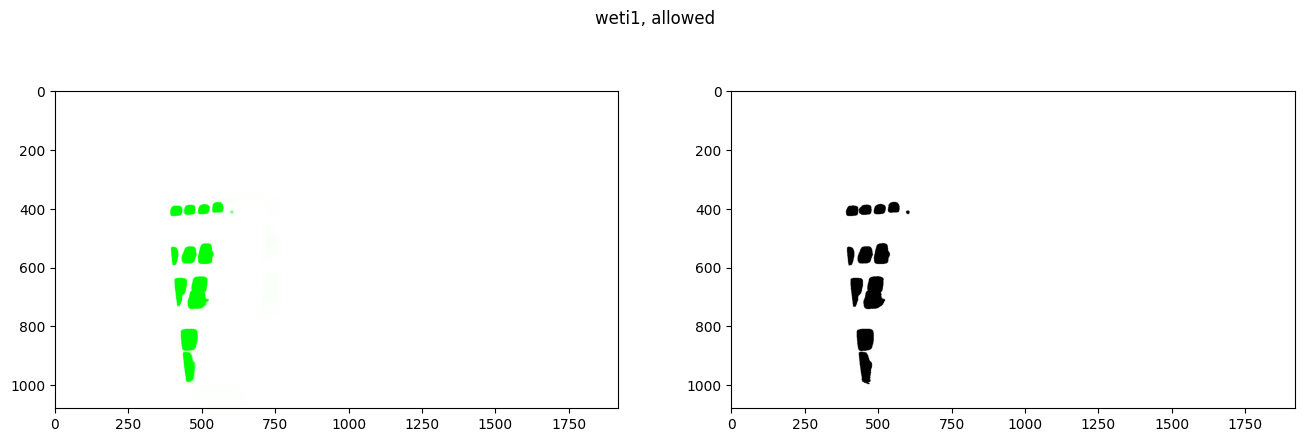

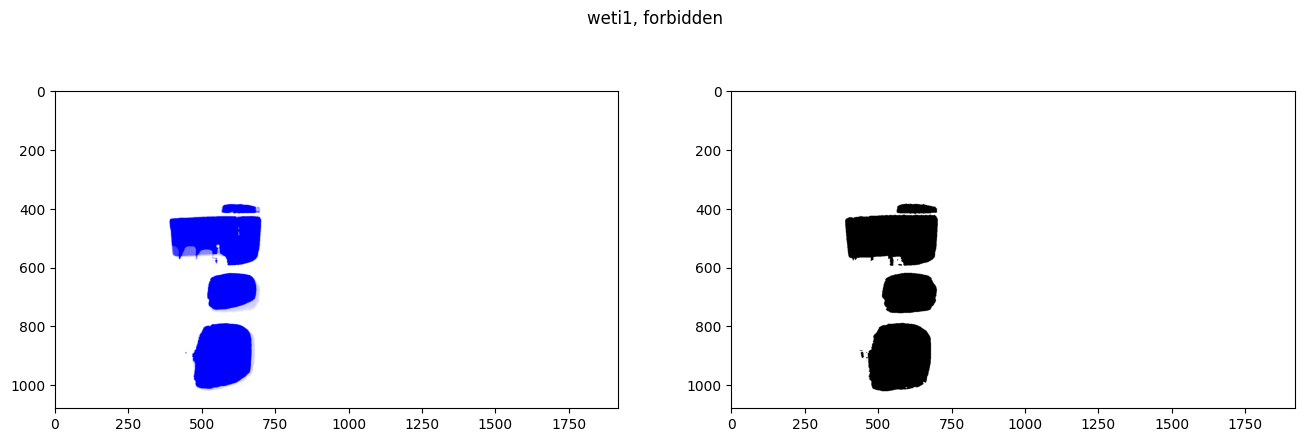

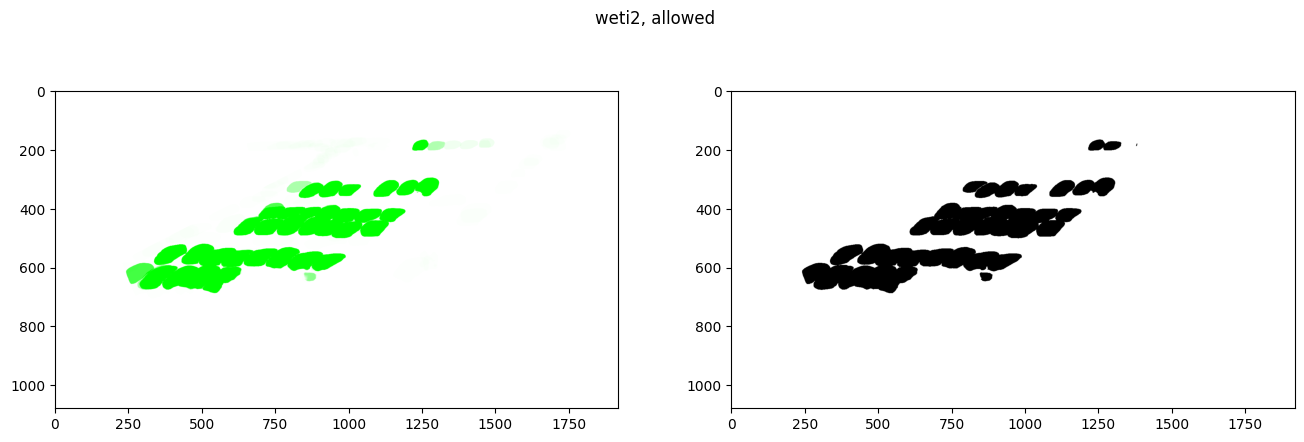

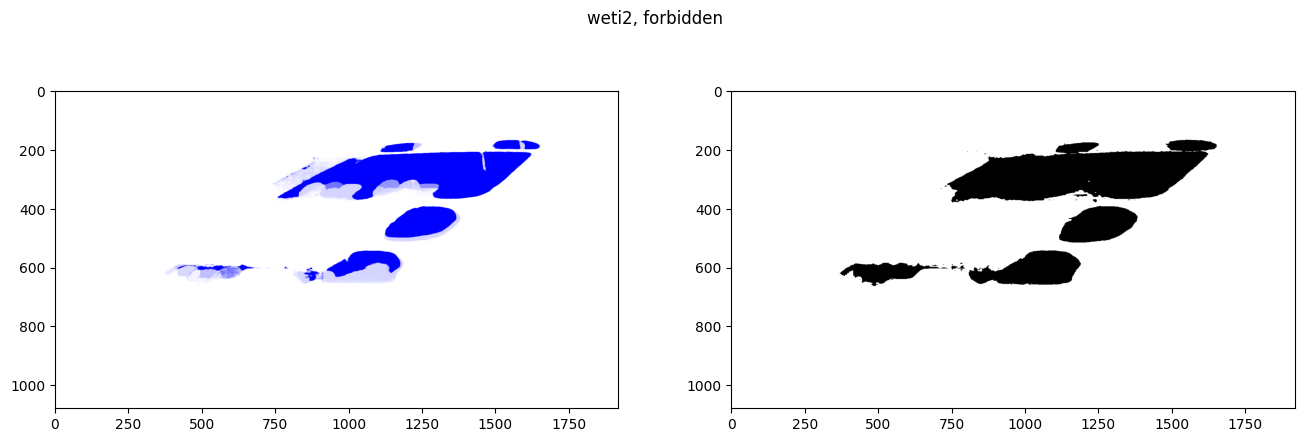

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti1_allowed)
axs[1].imshow(apply_threshold(mask_weti1_allowed, 0.1))
fig.suptitle("weti1, allowed")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti1_forbidden)
axs[1].imshow(apply_threshold(mask_weti1_forbidden, 0.001))
fig.suptitle("weti1, forbidden")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti2_allowed)
axs[1].imshow(apply_threshold(mask_weti2_allowed, 0.1))
fig.suptitle("weti2, allowed")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti2_forbidden)
axs[1].imshow(apply_threshold(mask_weti2_forbidden, 0.001))
fig.suptitle("weti2, forbidden")
fig.subplots_adjust(top=1.25)
plt.show()

### Full day, every 10th image

In [105]:
mask_weti1_allowed = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti1', 'allowed'])[::10], transparency=0.01)
mask_weti1_forbidden = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti1', 'forbidden'])[::10], transparency=0.01)
mask_weti2_allowed = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti2', 'allowed'])[::10], transparency=0.01)
mask_weti2_forbidden = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti2', 'forbidden'])[::10], transparency=0.01)

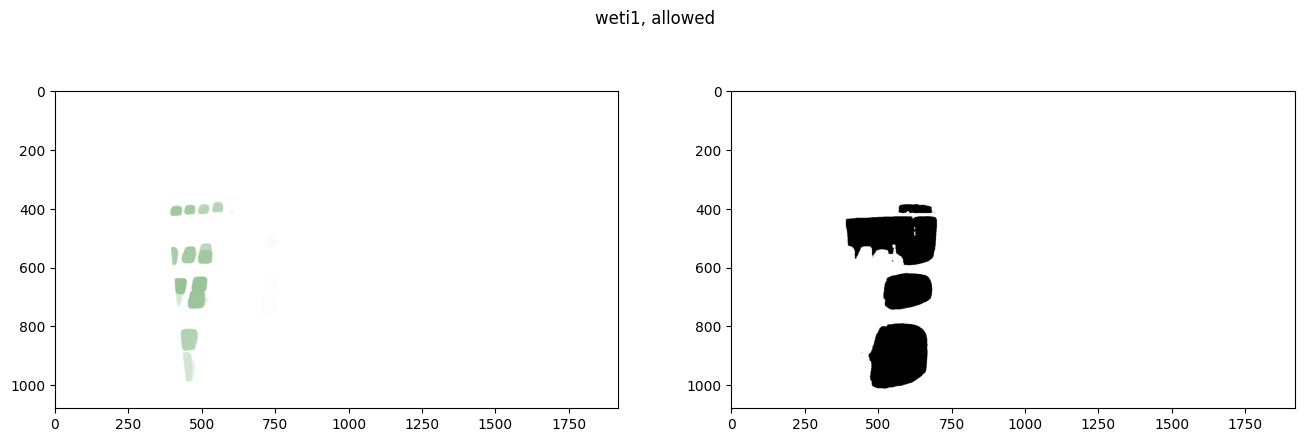

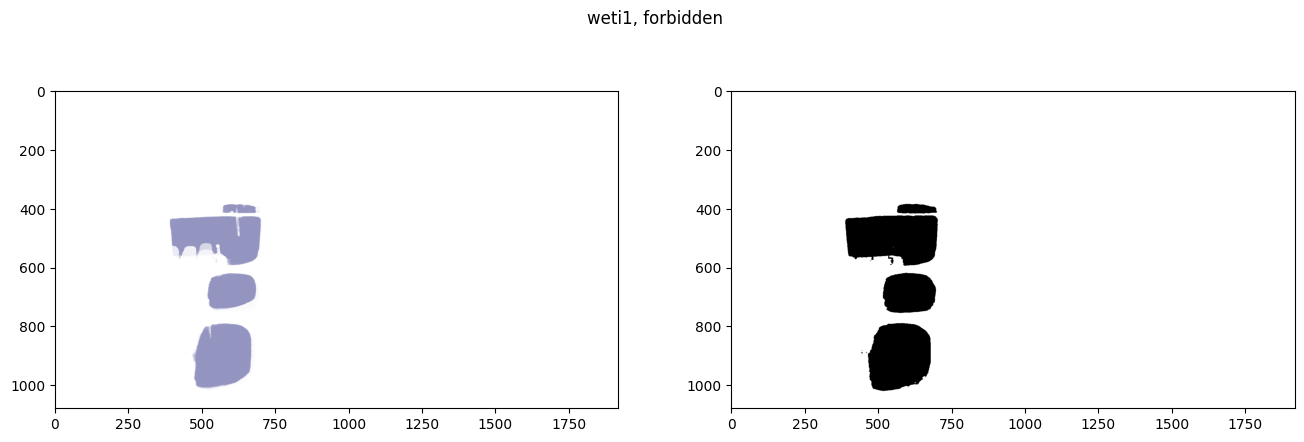

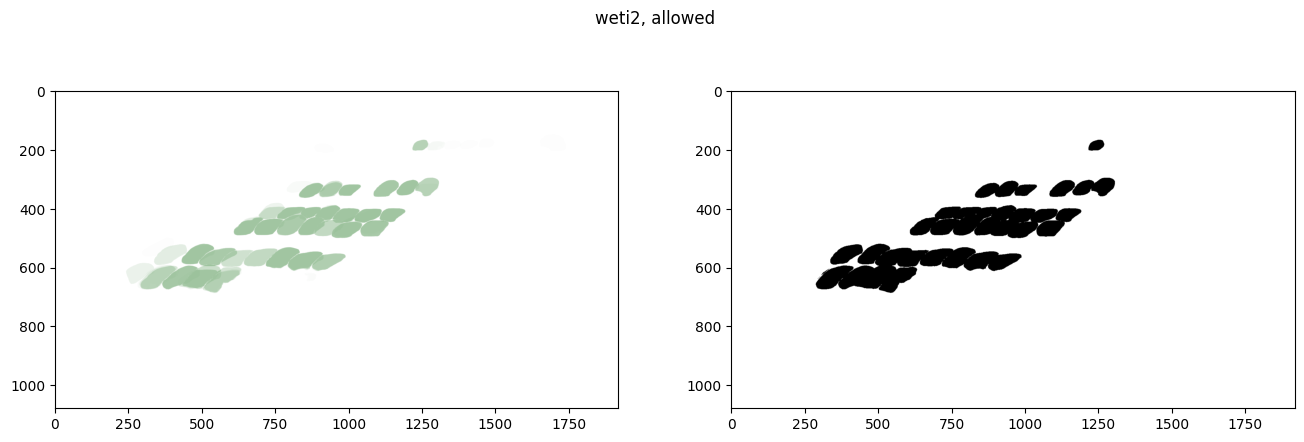

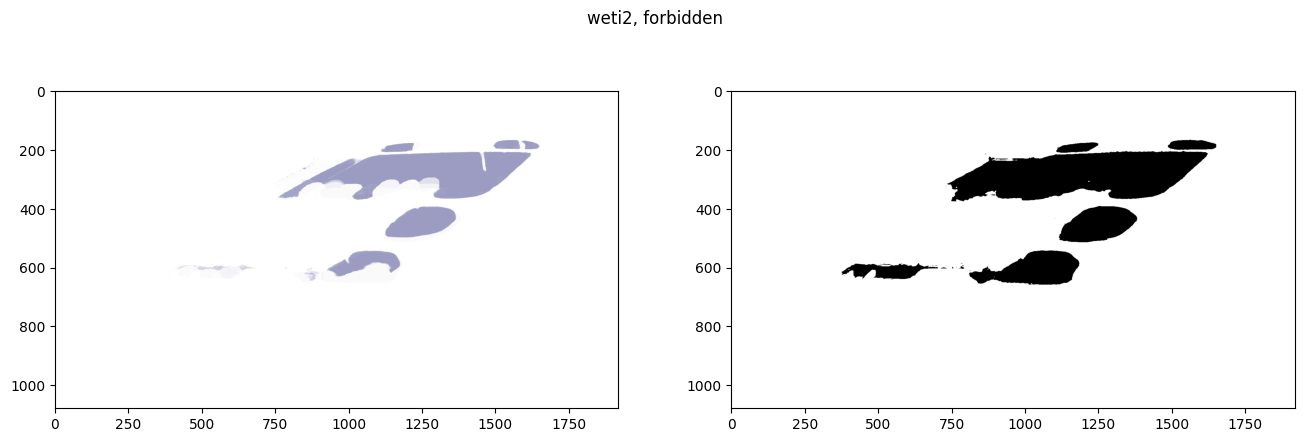

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti1_allowed)
axs[1].imshow(apply_threshold(mask_weti1_allowed, 0.1))
fig.suptitle("weti1, allowed")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti1_forbidden)
axs[1].imshow(apply_threshold(mask_weti1_forbidden, 0.001))
fig.suptitle("weti1, forbidden")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti2_allowed)
axs[1].imshow(apply_threshold(mask_weti2_allowed, 0.1))
fig.suptitle("weti2, allowed")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti2_forbidden)
axs[1].imshow(apply_threshold(mask_weti2_forbidden, 0.001))
fig.suptitle("weti2, forbidden")
fig.subplots_adjust(top=1.25)
plt.show()

### Bright, full day

In [114]:
mask_weti1_allowed = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti1', 'allowed'], [f"_{h}_" for h in range(16, 25)]), transparency=0.01)
mask_weti1_forbidden = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti1', 'forbidden'], [f"_{h}_" for h in range(16, 25)]), transparency=0.01)
mask_weti2_allowed = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti2', 'allowed'], [f"_{h}_" for h in range(16, 25)]), transparency=0.01)
mask_weti2_forbidden = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti2', 'forbidden'], [f"_{h}_" for h in range(16, 25)]), transparency=0.01)

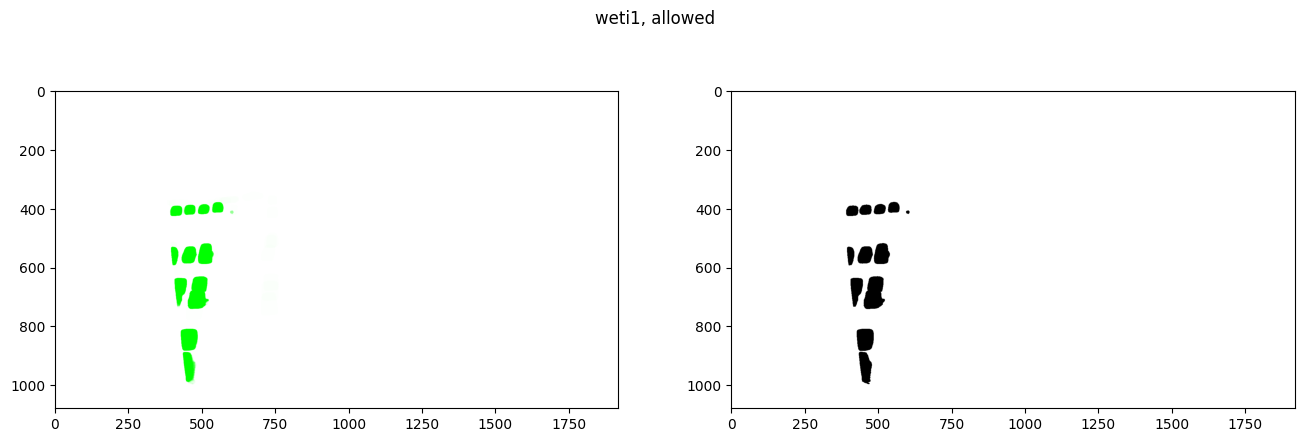

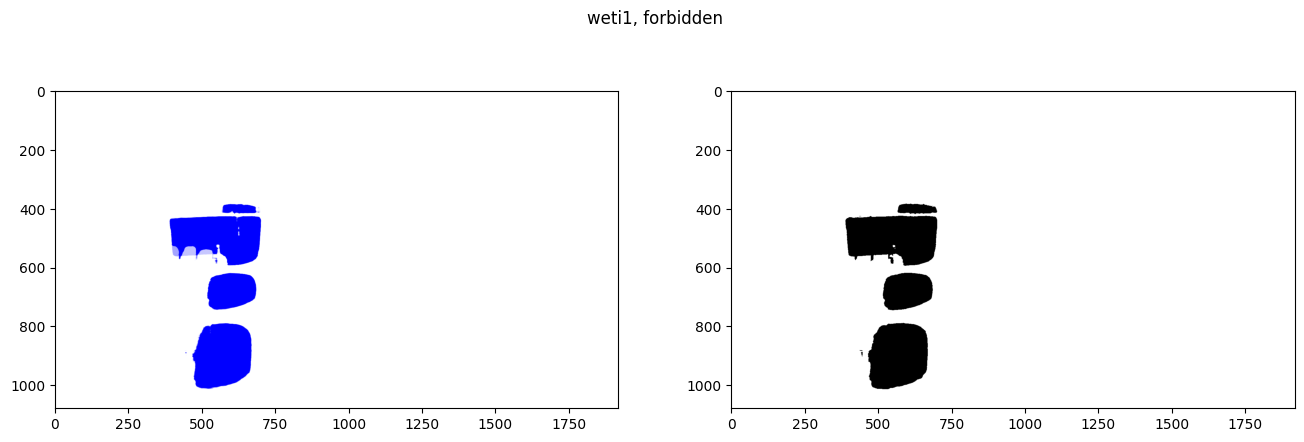

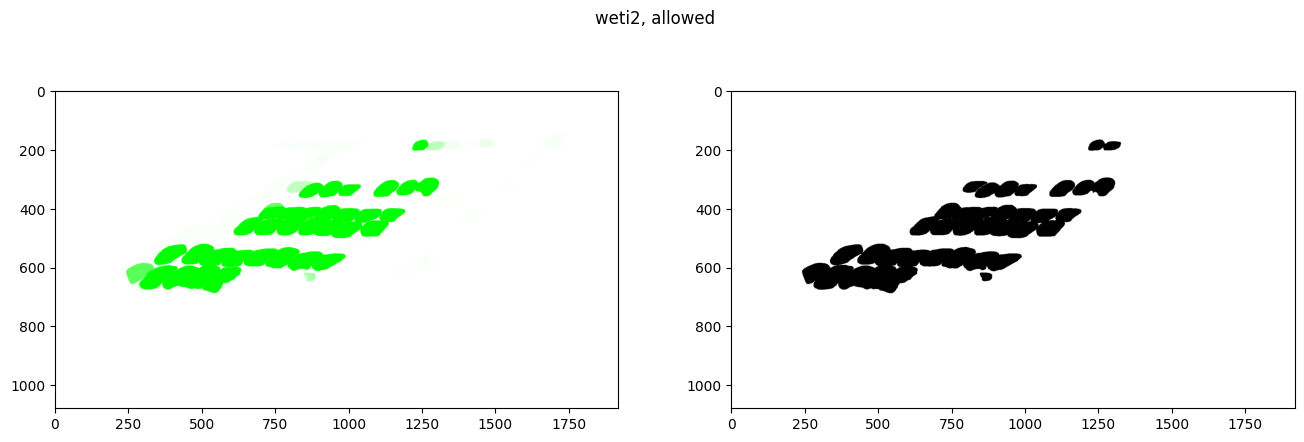

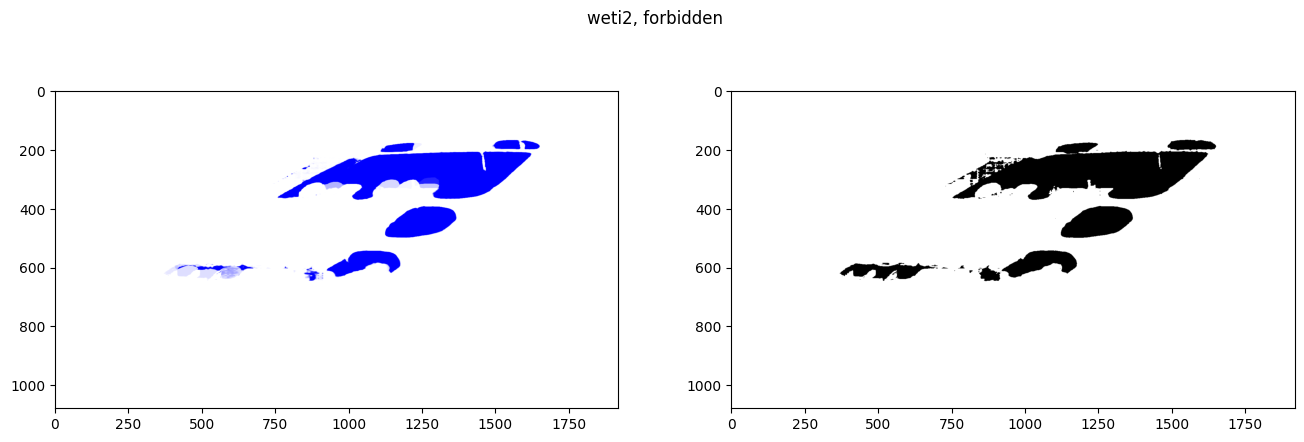

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti1_allowed)
axs[1].imshow(apply_threshold(mask_weti1_allowed, 0.1))
fig.suptitle("weti1, allowed")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti1_forbidden)
axs[1].imshow(apply_threshold(mask_weti1_forbidden, 0.001))
fig.suptitle("weti1, forbidden")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti2_allowed)
axs[1].imshow(apply_threshold(mask_weti2_allowed, 0.1))
fig.suptitle("weti2, allowed")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti2_forbidden)
axs[1].imshow(apply_threshold(mask_weti2_forbidden, 0.001))
fig.suptitle("weti2, forbidden")
fig.subplots_adjust(top=1.25)
plt.show()

#### Bright, every 10th image

In [ ]:
mask_weti1_allowed = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti1', 'allowed'], [f"_{h}_" for h in range(16, 25)])[::10], transparency=0.01)
mask_weti1_forbidden = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti1', 'forbidden'], [f"_{h}_" for h in range(16, 25)])[::10], transparency=0.01)
mask_weti2_allowed = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti2', 'allowed'], [f"_{h}_" for h in range(16, 25)])[::10], transparency=0.01)
mask_weti2_forbidden = combine_masks(fetch_image_paths(r'/mnt/c/Users/gtraw/Projekt_badawczy/allowed_forbidden_results', ['weti2', 'forbidden'], [f"_{h}_" for h in range(16, 25)])[::10], transparency=0.01)

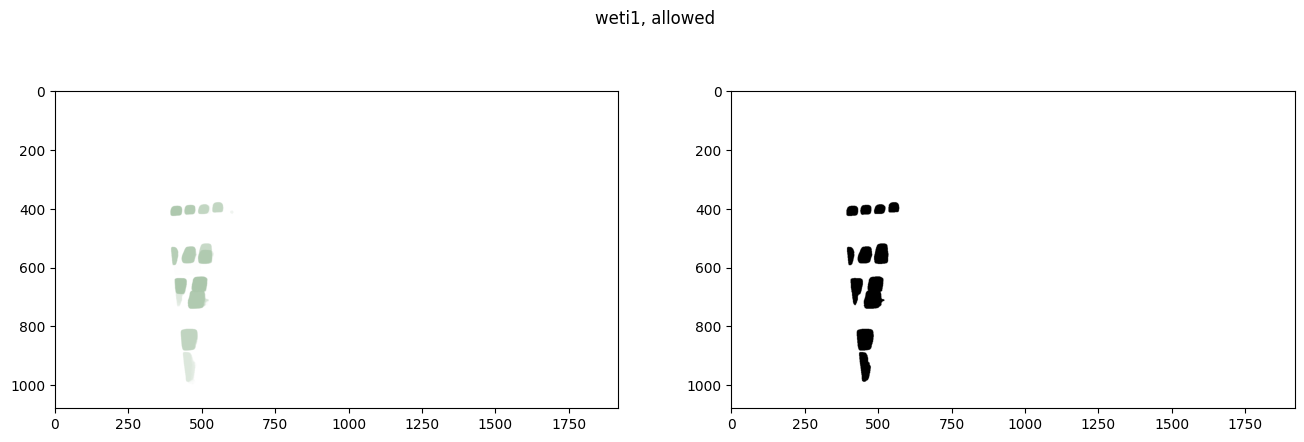

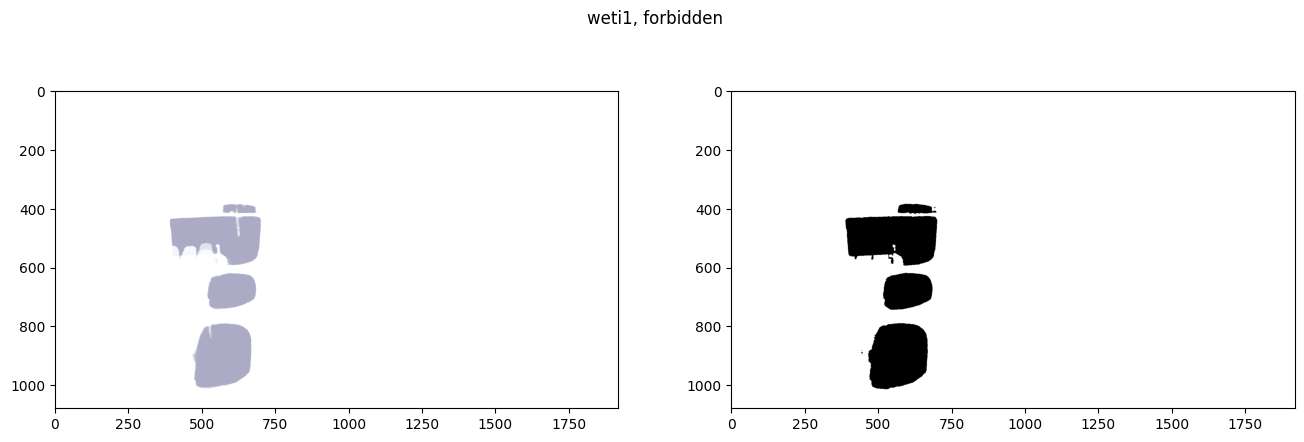

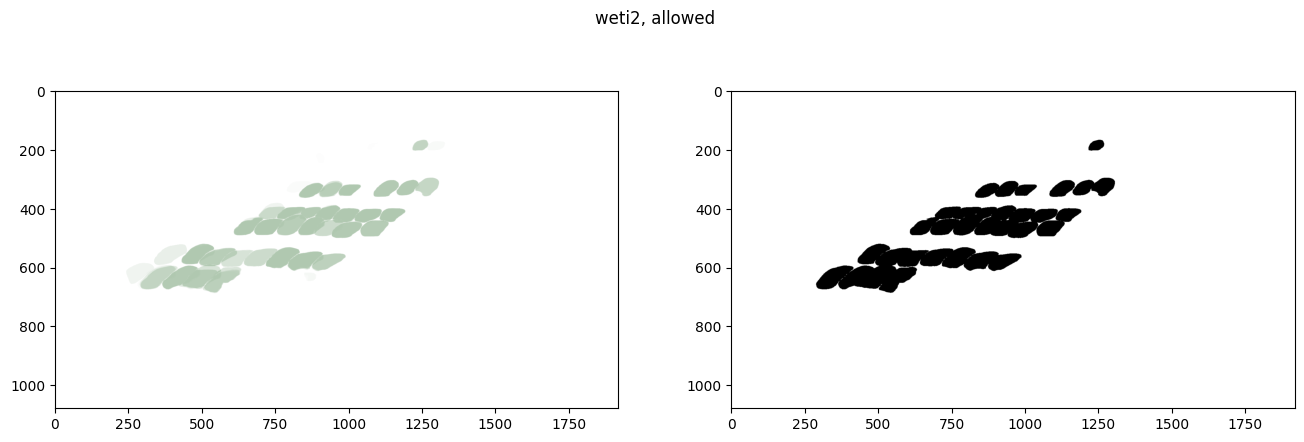

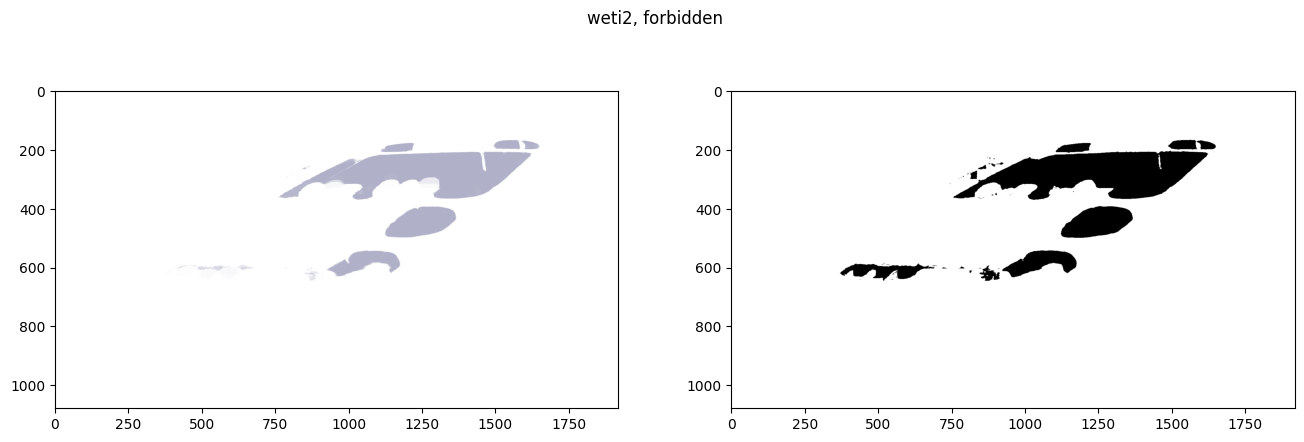

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti1_allowed)
axs[1].imshow(apply_threshold(mask_weti1_allowed, 0.1))
fig.suptitle("weti1, allowed")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti1_forbidden)
axs[1].imshow(apply_threshold(mask_weti1_forbidden, 0.001))
fig.suptitle("weti1, forbidden")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti2_allowed)
axs[1].imshow(apply_threshold(mask_weti2_allowed, 0.1))
fig.suptitle("weti2, allowed")
fig.subplots_adjust(top=1.25)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mask_weti2_forbidden)
axs[1].imshow(apply_threshold(mask_weti2_forbidden, 0.001))
fig.suptitle("weti2, forbidden")
fig.subplots_adjust(top=1.25)
plt.show()